In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

In [2]:
%cd ~/cdv

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [9]:
import json
import gc
from tqdm import tqdm
from pymatgen.core import Structure

with open('data/2023-02-07-mp-computed-structure-entries.json', 'r') as f:
    data = json.load(f)

In [12]:
len(data['material_id'])

154718

In [16]:
k = next(iter(data['entry']))
data['entry'][k]

{'@module': 'pymatgen.entries.computed_entries',
 '@class': 'ComputedStructureEntry',
 'energy': -0.06880822,
 'composition': {'Ar': 1.0},
 'entry_id': 'mp-23155-GGA',
 'correction': 0.0,
 'energy_adjustments': [],
 'parameters': {'potcar_spec': [{'titel': 'PAW_PBE Ar 07Sep2000',
    'hash': 'e782fc6292623b396091bf8b871c272f'}],
  'is_hubbard': False,
  'hubbards': {},
  'run_type': 'GGA'},
 'data': {'oxide_type': 'None',
  'aspherical': True,
  'last_updated': {'@module': 'datetime',
   '@class': 'datetime',
   'string': '2020-05-05 03:24:57.857000'},
  'task_id': 'mp-1476242',
  'material_id': 'mp-23155',
  'oxidation_states': {},
  'run_type': 'GGA'},
 'structure': {'@module': 'pymatgen.core.structure',
  '@class': 'Structure',
  'charge': 0,
  'lattice': {'matrix': [[0.0, 2.820386, 2.820386],
    [2.820386, 0.0, 2.820386],
    [2.820386, 2.820386, 0.0]],
   'pbc': [True, True, True],
   'a': 3.9886281323,
   'b': 3.9886281323,
   'c': 3.9886281323,
   'alpha': 60.0,
   'beta': 60.0

In [25]:
s = data['entry'][k]['structure']

In [28]:
from pymatgen.core import Structure
df = pd.DataFrame([{'energy': row['energy'], 'dataset-id': row['entry_id'], 'structure': Structure.from_dict(row['structure'])} for row in data['entry'].values()])
df.head()

,energy,dataset-id,structure
0,-0.068808,mp-23155-GGA,[[0. 0. 0.] Ar]
1,-5.370226,mp-1246134-GGA,[[0. 0. 0.] Ni]
2,-15.327756,mp-1182070-GGA,"[[1.1527025 4.05144414 4.93659732] Bi, [1.152..."
3,-6.581273,mp-569358-GGA,"[[0.38891127 0. 4.475856 ] Bi, [2.841..."
4,-30.313476,mp-1078637-GGA,"[[ 3.4040553 -2.26030098 3.4519655 ] Bi, [3...."


In [41]:
for i, inds in enumerate(np.array_split(df.index, 36)):
    df.loc[inds].to_pickle(f'precomputed/mp2022/raw/batch_{i:04}.pkl')
    print('.', end='')

....................................

In [36]:
df.to_pickle('precomputed/mp2022/dataframe.pkl')

In [31]:
pd.value_counts([str(s.pbc) for s in df['structure']])

/tmp/ipykernel_895045/3651471573.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts([str(s.pbc) for s in df['structure']])
/tmp/ipykernel_895045/3651471573.py:1: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts([str(s.pbc) for s in df['structure']])


(True, True, True)    154718
Name: count, dtype: int64

In [19]:
from cdv.databatch import CrystalGraphs, CrystalData, EdgeData, NodeData, MPTrjTarget
from pymatgen.core import Structure
batch_i = 1
i = 0
row = df.iloc[i]
struct: Structure = row['structure']

def knn_graph(struct: Structure, r_start=8, k=16):
    """returns (ijs, ims)
    ijs: nodes k
    ims: nodes k 3"""
    if r_start > 100:
        raise ValueError()
    graph_ijs = []
    graph_ims = []
    r = r_start
    for i, nbs in enumerate(struct.get_all_neighbors(r)):
        sites, dists, idxs, ims = zip(*nbs)
        if len(dists) < k:
            # print('Not enough neighbors, using r =', 2 * r_start)
            return knn_graph(struct, r_start=r * 2, k=k)
        
        chosen = np.argsort(dists)[:k]

        graph_ijs.append(np.array(idxs)[chosen])
        graph_ims.append(np.array(ims)[chosen])

    graph_ijs = np.stack(graph_ijs).astype(np.uint16)
    graph_ims = np.stack(graph_ims).astype(np.int8)

    return EdgeData(np.array(graph_ims), np.array(graph_ijs))


def create_graph(row, data_id):
    struct: Structure = row['structure']
    nodes = NodeData(
        species=jnp.array(struct.atomic_numbers, dtype=jnp.uint8),
        cart=jnp.array(struct.cart_coords, dtype=jnp.float32),
        graph_i=jnp.zeros((struct.num_sites,), dtype=jnp.uint16)
    )

    data = CrystalData(
        dataset_id=jnp.array([data_id], dtype=jnp.uint32),
        abc=jnp.array([struct.lattice.abc]),
        angles_rad=jnp.deg2rad(jnp.array([struct.lattice.angles])),
        lat=jnp.array([struct.lattice.matrix])
    )
    target = MPTrjTarget(
        e_form=jnp.array([row['energy_per_atom']]),    
        force=jnp.array(row['force']),
        stress=jnp.array([row['stress']]),
    )
    try:
        edges = knn_graph(struct)
    except ValueError as e:
        raise ValueError(f'{data_id}') from e

    return CrystalGraphs(nodes, edges, n_node=jnp.array([struct.num_sites], dtype=jnp.uint16), padding_mask=jnp.ones((1,), dtype=jnp.bool), graph_data=data, target_data=target)

for i in range(len(df.index)):
    for nbs in df['structure'].iloc[i].get_all_neighbors(8):
        if len(nbs) == 0:
            print(i)
            break

KeyboardInterrupt: 

In [17]:
# s = Structure(np.eye(3), ['C'], [[0.5, 0.5, 0.5]])
for nbs in struct.get_all_neighbors(r=16):
    dists = list(zip(*nbs))[1]
    print(len(dists))

1910
1917
1914
1916
1908
1908
1902
1910
1910
1902
1912
1922
1911
1905
1911
1905
1916
1912
1912
1916
1913
1916
1916
1913
1916
1919
1909
1909
1919
1916
1910
1909


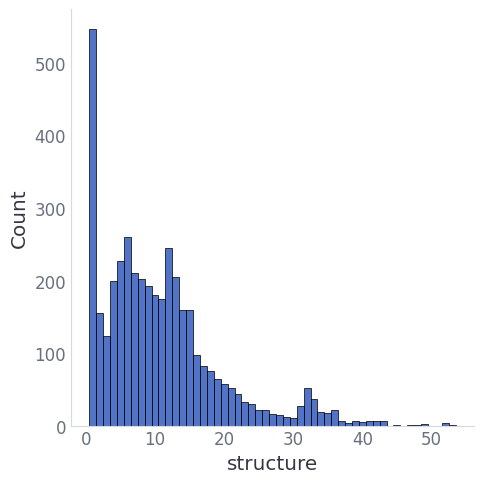

In [6]:
sns.displot(df.groupby('mp_id').count()['structure'], discrete=True)

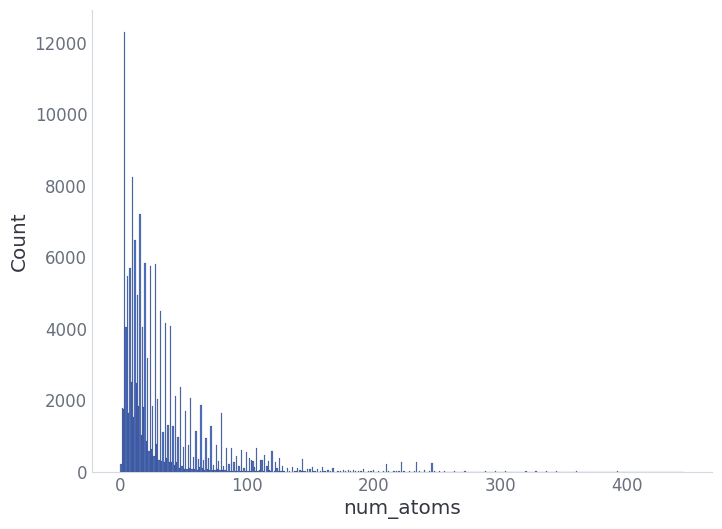

In [32]:
df['num_atoms'] = [s.num_sites for s in df['structure']]
sns.histplot(df['num_atoms'], discrete=True)
print(df['num_atoms'].describe())
rp.smart_ticks()

In [34]:
from pathlib import Path
from tqdm import tqdm
import numpy as np

num_batch = 31
num_atoms = 32
target_batch_size = (num_batch + 1) * num_atoms - 1

def get_parts(numbers, batch, chunk_size):
    """Splits the numbers into batches of length batch with as equal a split as possible."""
    # assert len(numbers) % (batch * chunk_size) == 0
    n_batches = len(numbers) // batch
    parts = np.zeros((batch, n_batches), dtype=jnp.int32)
    part_sizes = np.array([0 for _ in range(n_batches)])
    
    chunk_i = 0
    for sample_is in np.argsort(-numbers).reshape(batch // chunk_size, chunk_size * n_batches):
        sample_sizes = numbers[sample_is]
        n_filled = np.zeros((n_batches,), dtype=jnp.int32)
        for sample_i, sample_size in zip(sample_is, sample_sizes):
            next_i = np.argmin(part_sizes + 10000 * (n_filled == chunk_size))
            parts[chunk_i * chunk_size + n_filled[next_i], next_i] += sample_i
            n_filled[next_i] += 1
            part_sizes[next_i] += sample_size
        chunk_i += 1

    return parts, part_sizes

def padded_parts(sizes, extra=0):
    data_pad = -len(sizes) % num_batch + num_batch * extra
    pad_sizes = np.array(list(sizes) + [0] * data_pad)
    parts, part_sizes = get_parts(pad_sizes, num_batch, num_batch)
    if max(part_sizes) > target_batch_size:
        return padded_parts(sizes, extra + 4)
    else:
        return parts, part_sizes 

max_sizes = []
# for batch_fn in tqdm(list(Path('precomputed/mptrj/raw').glob('batch_*.pkl'))[15:16]):
#     df = pd.read_pickle(batch_fn)
sizes = [s.num_sites for s in df['structure']]

orig_size = len(sizes)
parts, part_sizes = padded_parts(sizes)
part_sizes

array([979, 979, 978, ..., 974, 974, 974])

In [49]:
mp_id = df['mp_id'].str.removeprefix('mp-').astype(int) * 10_000
mp_id += df['calc'] * 1_000
mp_id += df['step']
mp_id

0        15182600003
1        15182600002
2        15188260002
3        15193570002
4        15193570000
            ...     
44757    11109860005
44758    11109860004
44759    11109860003
44760    11109860002
44761    11109860000
Name: mp_id, Length: 44762, dtype: int64

In [10]:
cgs = [create_graph(df.iloc[i], i) for i in parts[:, 0] if i < orig_size]

In [11]:
from cdv.utils import debug_stat, debug_structure

debug_structure(sum(cgs[1:], start=cgs[0]));

arg0 >>> CrystalGraphs
├── nodes
│   ├── species
│   │   └── u8[952]
│   ├── cart
│   │   └── f32[952, 3]
│   └── graph_i
│       └── u16[952]
├── edges
│   ├── to_jimage
│   │   └── i8[952, 16, 3]
│   └── receiver
│       └── u16[952, 16]
├── n_node
│   └── u16[31]
├── padding_mask
│   └── bool[31]
├── graph_data
│   ├── dataset_id
│   │   └── u32[31]
│   ├── abc
│   │   └── f32[31, 3]
│   ├── angles_rad
│   │   └── f32[31, 3]
│   └── lat
│       └── f32[31, 3, 3]
└── target_data
    ├── e_form
    │   └── f32[31]
    ├── force
    │   └── f32[952, 3]
    └── stress
        └── f32[31, 3, 3]